# Estimator properties - 3

In [2]:
import numpy as np
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
import pickle
import sys
import os

sys.path.append("../src/")
from Hypergraphs import CompleteHypergraph
from simulate_gillespie import gillespie_sim
from solve_kolmogorov import *
from estimate_total_rates import *

## Setup

In [3]:
## --- Setup --- ##
test_name = "multi_run_gillespie_generation"

g_type = "complete"
N = 100
g = CompleteHypergraph(N)

nruns = 30 # number of independent estimation runs per regime
nsims = 100 # number of Gillespie simulations within each run

time_max = 10.0   # shorter time for faster testing

betas_unscaled_selected = [(1.778, 2.552), (2.556, 8.241), (5.667, 13.414)]
mu = 1.0

# NOTE: currently using a single I0 for all sims within a run
I0 = 1
I0_gillespie = 1

## Generate Gillespie simulation data

In [4]:
generate_gillespie_data = False
if generate_gillespie_data:
    # set base output dir
    output_base_dir = "../results/estimation_3"
    os.makedirs(output_base_dir, exist_ok= True)

    # for all regimes
    for regime in range(len(betas_unscaled_selected)):
        print(f"\n Generating for regime: {regime} ...")

        # select and scale betas for the current regime and N
        betas_unscaled = betas_unscaled_selected[regime]
        beta1 = betas_unscaled[0] / N       # pairwise infection rate
        beta2 = betas_unscaled[1] / (N**2)  # higher-order infection rate

        print(f" beta1 * N = {beta1 * N:.4f}, beta2 * N^2 = {beta2 * (N**2):.4f}")

        # regime specific output dir
        regime_dir = os.path.join(output_base_dir, f"regime_{regime}")
        os.makedirs(regime_dir, exist_ok=True)

        # run nruns of independent Gillepsie runs
        for nrun in range(nruns):
            print(f" Starting run: {nrun} for regime: {regime} ...")

            # TODO: could loop over initial infections
            # I0_gillespie in .1 N, .2 N, ...
            initial_infections = list(range(I0_gillespie))

            # generate and save sims for this run
            X_sims_current_run = []
            for sim_num in range(nsims):
                X_t = gillespie_sim(
                    g, beta1, beta2, mu, initial_infections, time_max)
                X_sims_current_run.append(X_t)
            
            output_filename = os.path.join(regime_dir, f"gillespie-sims_r{nrun}.npz")
            sim_results_to_save = {f'sim_{i}': X_sims_current_run[i] for i in range(nsims)}
            
            np.savez_compressed(output_filename, **sim_results_to_save)
            print(f"  Run {nrun} results saved to {output_filename}")

    print(f"\nDone generating sims.")

## Plot the average curves

In [5]:
delta_t = 0.1   # Time step for calculating the average curve

results_base_dir = "../results/estimation_3"
figure_base_dir = "../figures/estimation_3/complete"
figure_dir = os.path.join(figure_base_dir, test_name)
os.makedirs(figure_dir, exist_ok=True) # Ensure figure directory exists

## Add solutions of KEs


Plot saved to ../figures/estimation_3/complete/multi_run_avg_vs_KE/gillespie_avg_vs_KE_N100.pdf


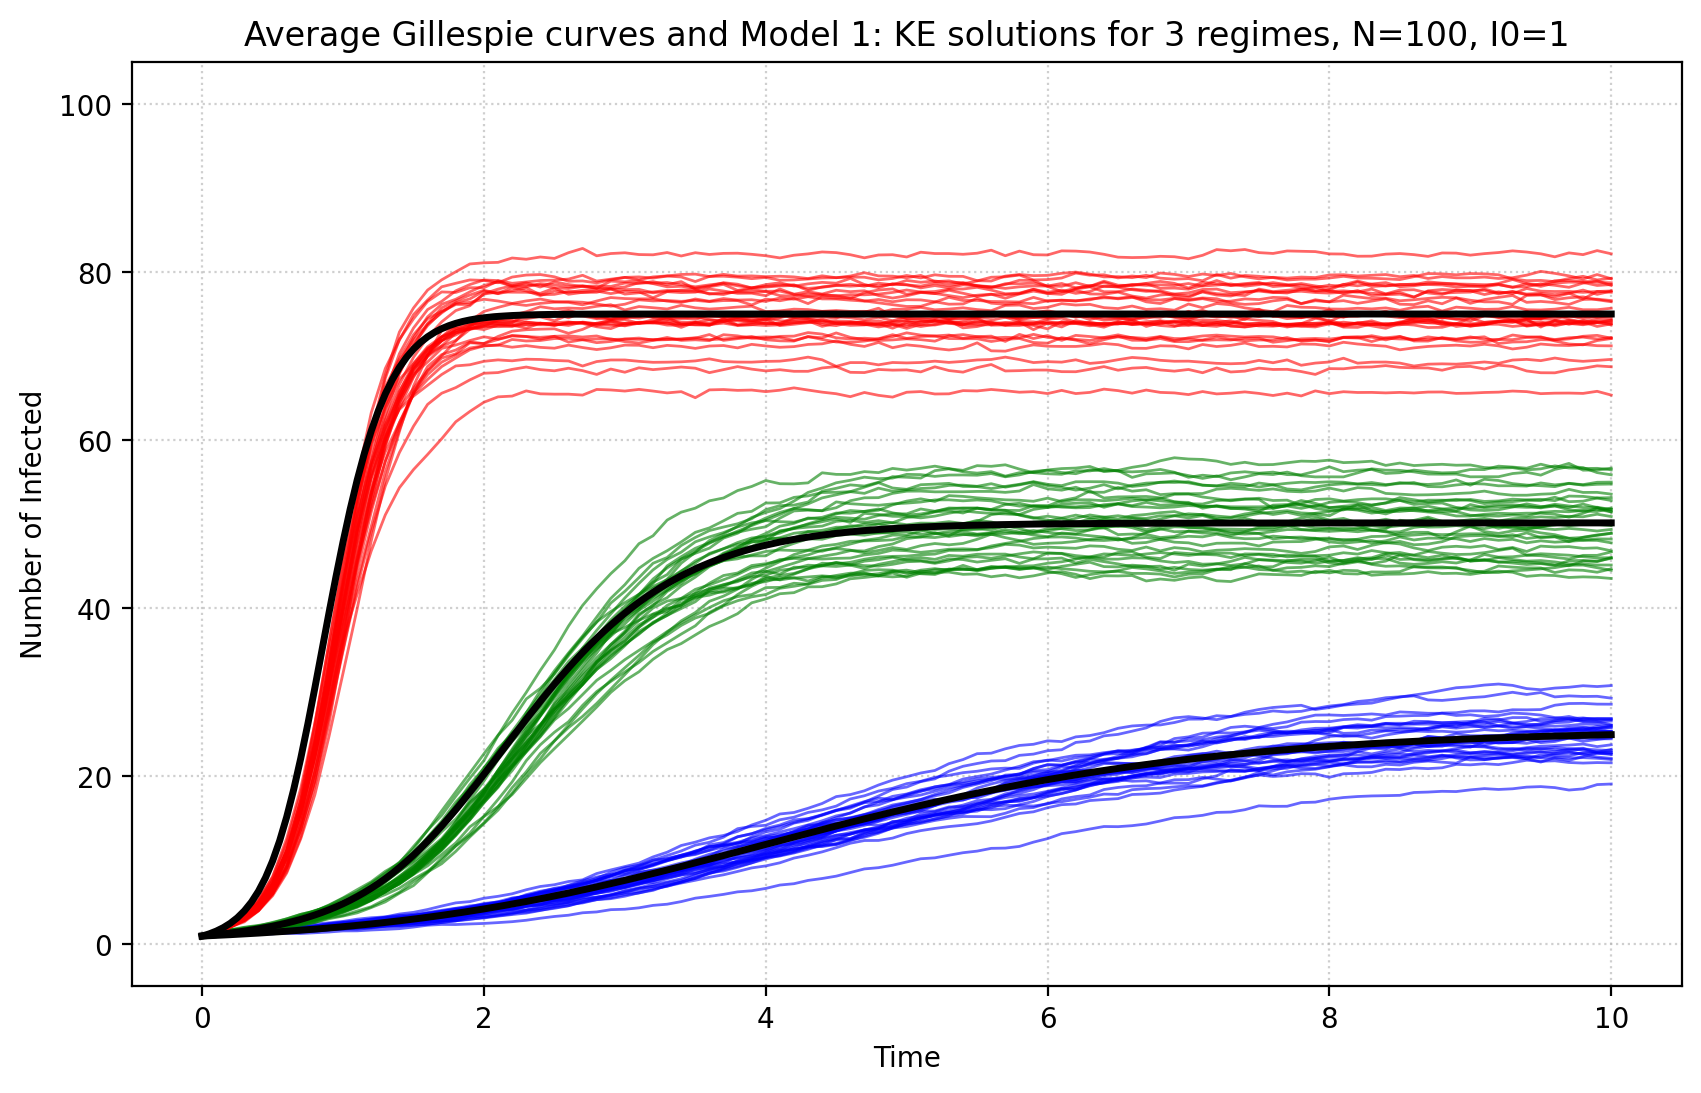

In [28]:
## --- Setup --- ##
test_name = "multi_run_avg_vs_KE"

I0_compare = 1

betas_unscaled_selected = [(1.778, 2.552), (2.556, 8.241), (5.667, 13.414)]

results_base_dir = "../results/estimation_3"
figure_base_dir = "../figures/estimation_3/complete"
figure_dir = os.path.join(figure_base_dir, test_name)
os.makedirs(figure_dir, exist_ok=True)

# colors and labels for 3 regimes
colors = ['blue', 'green', 'red'] 
regime_labels = [r'$k^* = 0.25N$', r'$k^* = 0.50N$', r'$k^* = 0.75N$']

fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

# setup for KEs solver
M = N + 1
p0 = np.zeros(M)
p0[I0_compare] = 1.0


nsteps_ke = 201 # TODO: more steps for smoother curves
t_span_ke = (0.0, time_max)
t_eval_ke = np.linspace(t_span_ke[0], t_span_ke[1], nsteps_ke)

for regime in range(len(colors)):
    regime_color = colors[regime]
    regime_results_dir = os.path.join(results_base_dir, f"regime_{regime}")

    betas_unscaled = betas_unscaled_selected[regime]
    beta1 = betas_unscaled[0] / N
    beta2 = betas_unscaled[1] / (N**2)

    # solve ode system
    ode_system_true = list_all_ODEs_complete(g, beta1, beta2, mu)

    sol_ke = solve_ivp(lambda t, p: ode_system_true(t, p),
                        t_span_ke,
                        p0,
                        t_eval=t_eval_ke,
                        method="LSODA")    
    expected_values_ke = calculate_expected_values(sol_ke)

    # and plot on top
    ax.plot(sol_ke.t, expected_values_ke,
            color='black',
            linewidth=2.5,
            zorder=3) # plot on top

    times_avg = None # store time grid from get_average
    for nrun in range(nruns):
        run_filename = os.path.join(regime_results_dir, f"gillespie-sims_r{nrun}.npz")


        sim_results = np.load(run_filename, allow_pickle=True)
        num_sims_in_file = len(sim_results.files)
        X_sims = [sim_results[f'sim_{i}'] for i in range(num_sims_in_file)]

        # individual simulations plot
        # for sim_idx, X_t in enumerate(X_sims):
        #      if X_t.shape[1] > 0:
        #          ax.plot(X_t[0], X_t[2], color=regime_color, alpha=0.05, linewidth=0.2, rasterized=True, zorder=1)

        # calculate the average curve for this run
        avg_curve, times_avg = get_average(X_sims, time_max, num_sims_in_file, delta_t=delta_t, selected=2)

        # plot the average curve for this run
        label_avg = f"Gillespie average for regime {regime}" if nrun == 0 else None
        ax.plot(times_avg, avg_curve,
                color=regime_color,
                alpha=0.6,
                linewidth=1.0,
                label=None,
                zorder=2)

ax.set_xlabel("Time")
ax.set_ylabel("Number of Infected")
ax.set_title(f"Average Gillespie curves and Model 1: KE solutions for 3 regimes, N={N}, I0={I0_compare}")
ax.grid(True, linestyle=':', alpha=0.6)

ax.set_ylim(bottom=-N*0.05, top=N*1.05)

output_plot_filename = os.path.join(figure_dir, f"gillespie_avg_vs_KE_N{N}.pdf")

plt.savefig(output_plot_filename, format='pdf', bbox_inches='tight')
print(f"\nPlot saved to {output_plot_filename}")

plt.show()
plt.close(fig)

## Calculate and plot the estimates

In [27]:
## --- Setup --- ##
test_name = "estimate_variability"


selected_regime = 0

betas_unscaled = betas_unscaled_selected[selected_regime]
beta1 = betas_unscaled[0] / N
beta2 = betas_unscaled[1] / (N**2)

results_base_dir = "../results/estimation_3"
regime_results_dir = os.path.join(results_base_dir, f"regime_{selected_regime}")
figure_base_dir = "../figures/estimation_3/complete"
figure_dir = os.path.join(figure_base_dir, test_name, f"regime_{selected_regime}")
os.makedirs(figure_dir, exist_ok=True)

# prepare storage to calculate estimates for each run
all_ak_hats = []
all_bk_hats = []
all_ck_hats = []
all_valid_k_masks = [] # ks with valid estimates above min_Tk_threshold in each run

min_Tk_threshold = 1e-6

for nrun in range(nruns):
    run_filename = os.path.join(regime_results_dir, f"gillespie-sims_r{nrun}.npz")

    sim_results = np.load(run_filename, allow_pickle=True)
    num_sims_in_file = len(sim_results.files)
    X_sims = [sim_results[f'sim_{i}'] for i in range(num_sims_in_file)]

    estimates = calculate_estimates(X_sims, N, min_Tk_threshold)

    all_ak_hats.append(estimates["a_k_hat"])
    all_bk_hats.append(estimates["b_k_hat"])
    all_ck_hats.append(estimates["c_k_hat"])
    all_valid_k_masks.append(estimates["T_k"] > min_Tk_threshold)

    print(f" Processed run {nrun}")


# lists of arrays to 2D arrays: runs x states (nruns, N + 1)
ak_hat_runs = np.array(all_ak_hats)
bk_hat_runs = np.array(all_bk_hats)
ck_hat_runs = np.array(all_ck_hats)
valid_k_masks_runs = np.array(all_valid_k_masks)

# calculate mean and std deviation of estimates
k_values = np.arange(N + 1)
mean_ak_hat = np.full(N + 1, np.nan)
std_ak_hat = np.full(N + 1, np.nan)
mean_bk_hat = np.full(N + 1, np.nan)
std_bk_hat = np.full(N + 1, np.nan)
mean_ck_hat = np.full(N + 1, np.nan)
std_ck_hat = np.full(N + 1, np.nan)
n_valid_runs_per_k = np.zeros(N + 1, dtype=int)

for k in k_values:
    # only valid k's
    valid_mask_for_k = valid_k_masks_runs[:, k]
    n_valid = np.sum(valid_mask_for_k)
    n_valid_runs_per_k[k] = n_valid

    if n_valid > 0:
        mean_ak_hat[k] = np.mean(ak_hat_runs[valid_mask_for_k, k])
        mean_bk_hat[k] = np.mean(bk_hat_runs[valid_mask_for_k, k])
        mean_ck_hat[k] = np.mean(ck_hat_runs[valid_mask_for_k, k])

        if n_valid > 1:
            std_ak_hat[k] = np.std(ak_hat_runs[valid_mask_for_k, k], ddof=1)
            std_bk_hat[k] = np.std(bk_hat_runs[valid_mask_for_k, k], ddof=1)
            std_ck_hat[k] = np.std(ck_hat_runs[valid_mask_for_k, k], ddof=1)
        else: # std dev to 0
             std_ak_hat[k] = 0
             std_bk_hat[k] = 0
             std_ck_hat[k] = 0

plot_valid_k_idx = ~np.isnan(mean_ak_hat)

# theoretical rates
k_choose_2 = np.array([comb(k, 2, exact=True) if k >= 2 else 0 for k in k_values])
a_k_true = beta1 * k_values * (N - k_values)
b_k_true = beta2 * k_choose_2 * (N - k_values)
c_k_true = mu * k_values

def plot_estimate_errorbars(k_vals, true_rates, mean_estimates, std_estimates, valid_idx,
                            color, rate_label, estimate_label, ylabel, title, filename):
    fig, ax = plt.subplots(figsize=(8, 5), dpi=150)

    # theoretical curves
    ax.plot(k_vals, true_rates, color='black', linestyle='-', linewidth=2, label=rate_label + ' (True)')

    # mean estimates with error bars (std deviations)
    ax.errorbar(k_vals[valid_idx], mean_estimates[valid_idx], yerr=std_estimates[valid_idx],
                fmt='.', color=color, markersize=5, elinewidth=1, capsize=3, alpha=0.8,
                label=estimate_label + ' (Mean ± SD)')

    ax.set_xlabel("Number of Infected")
    ax.set_ylabel(ylabel)
    ax.set_title(title + f"\n{nruns} runs of regime = {selected_regime}, N = {N}, I0 = {I0}")
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.set_xlim(left=-1, right=N+1)
    ax.set_ylim(bottom=min(0, np.nanmin(mean_estimates[valid_idx] - std_estimates[valid_idx])) - 0.1 * np.nanmax(true_rates) if np.any(valid_idx) else 0)

    
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    print(f"  Saved plot: {os.path.basename(filename)}")
    
    plt.close(fig) # free memory

# generate 3 plots
plot_estimate_errorbars(k_values, a_k_true, mean_ak_hat, std_ak_hat, plot_valid_k_idx,
                        'red', r'$a_k$', r'$\widehat{a}_k$', 'Rates and Counts', '',
                        os.path.join(figure_dir, f"estimates_ak_mean_sd_N{N}_reg{selected_regime}.pdf"))

plot_estimate_errorbars(k_values, b_k_true, mean_bk_hat, std_bk_hat, plot_valid_k_idx,
                        'blue', r'$b_k$', r'$\widehat{b}_k$', 'Rates and Counts', '',
                        os.path.join(figure_dir, f"estimates_bk_mean_sd_N{N}_reg{selected_regime}.pdf"))

plot_estimate_errorbars(k_values, c_k_true, mean_ck_hat, std_ck_hat, plot_valid_k_idx,
                        'green', r'$c_k$', r'$\widehat{c}_k$', 'Rates and Counts', '',
                        os.path.join(figure_dir, f"estimates_ck_mean_sd_N{N}_reg{selected_regime}.pdf"))

Skipping: duration = -0.0017504330934681178, event_index = None, index = 781, sim = 0
Skipping: duration = -0.005556821774913345, event_index = None, index = 724, sim = 3
Skipping: duration = -0.016612123339484697, event_index = None, index = 791, sim = 5
Skipping: duration = -0.009511922471482137, event_index = None, index = 411, sim = 6
Skipping: duration = -0.006765683800830757, event_index = None, index = 642, sim = 7
Skipping: duration = -0.02169042266772614, event_index = None, index = 742, sim = 13
Skipping: duration = -0.019586935752370138, event_index = None, index = 816, sim = 14
Skipping: duration = -0.008107642717911645, event_index = None, index = 511, sim = 18
Skipping: duration = -0.018414455917005412, event_index = None, index = 691, sim = 21
Skipping: duration = -0.008541040484860929, event_index = None, index = 1042, sim = 25
Skipping: duration = -0.0023179262126369338, event_index = None, index = 906, sim = 26
Skipping: duration = -0.0043613106897471, event_index = N

## Solve KEs using the estimates 

In [11]:
from matplotlib.lines import Line2D # For custom legend


 Processing 30 runs for regime 0 ...
Skipping: duration = -0.0017504330934681178, event_index = None, index = 781, sim = 0
Skipping: duration = -0.005556821774913345, event_index = None, index = 724, sim = 3
Skipping: duration = -0.016612123339484697, event_index = None, index = 791, sim = 5
Skipping: duration = -0.009511922471482137, event_index = None, index = 411, sim = 6
Skipping: duration = -0.006765683800830757, event_index = None, index = 642, sim = 7
Skipping: duration = -0.02169042266772614, event_index = None, index = 742, sim = 13
Skipping: duration = -0.019586935752370138, event_index = None, index = 816, sim = 14
Skipping: duration = -0.008107642717911645, event_index = None, index = 511, sim = 18
Skipping: duration = -0.018414455917005412, event_index = None, index = 691, sim = 21
Skipping: duration = -0.008541040484860929, event_index = None, index = 1042, sim = 25
Skipping: duration = -0.0023179262126369338, event_index = None, index = 906, sim = 26
Skipping: duration 

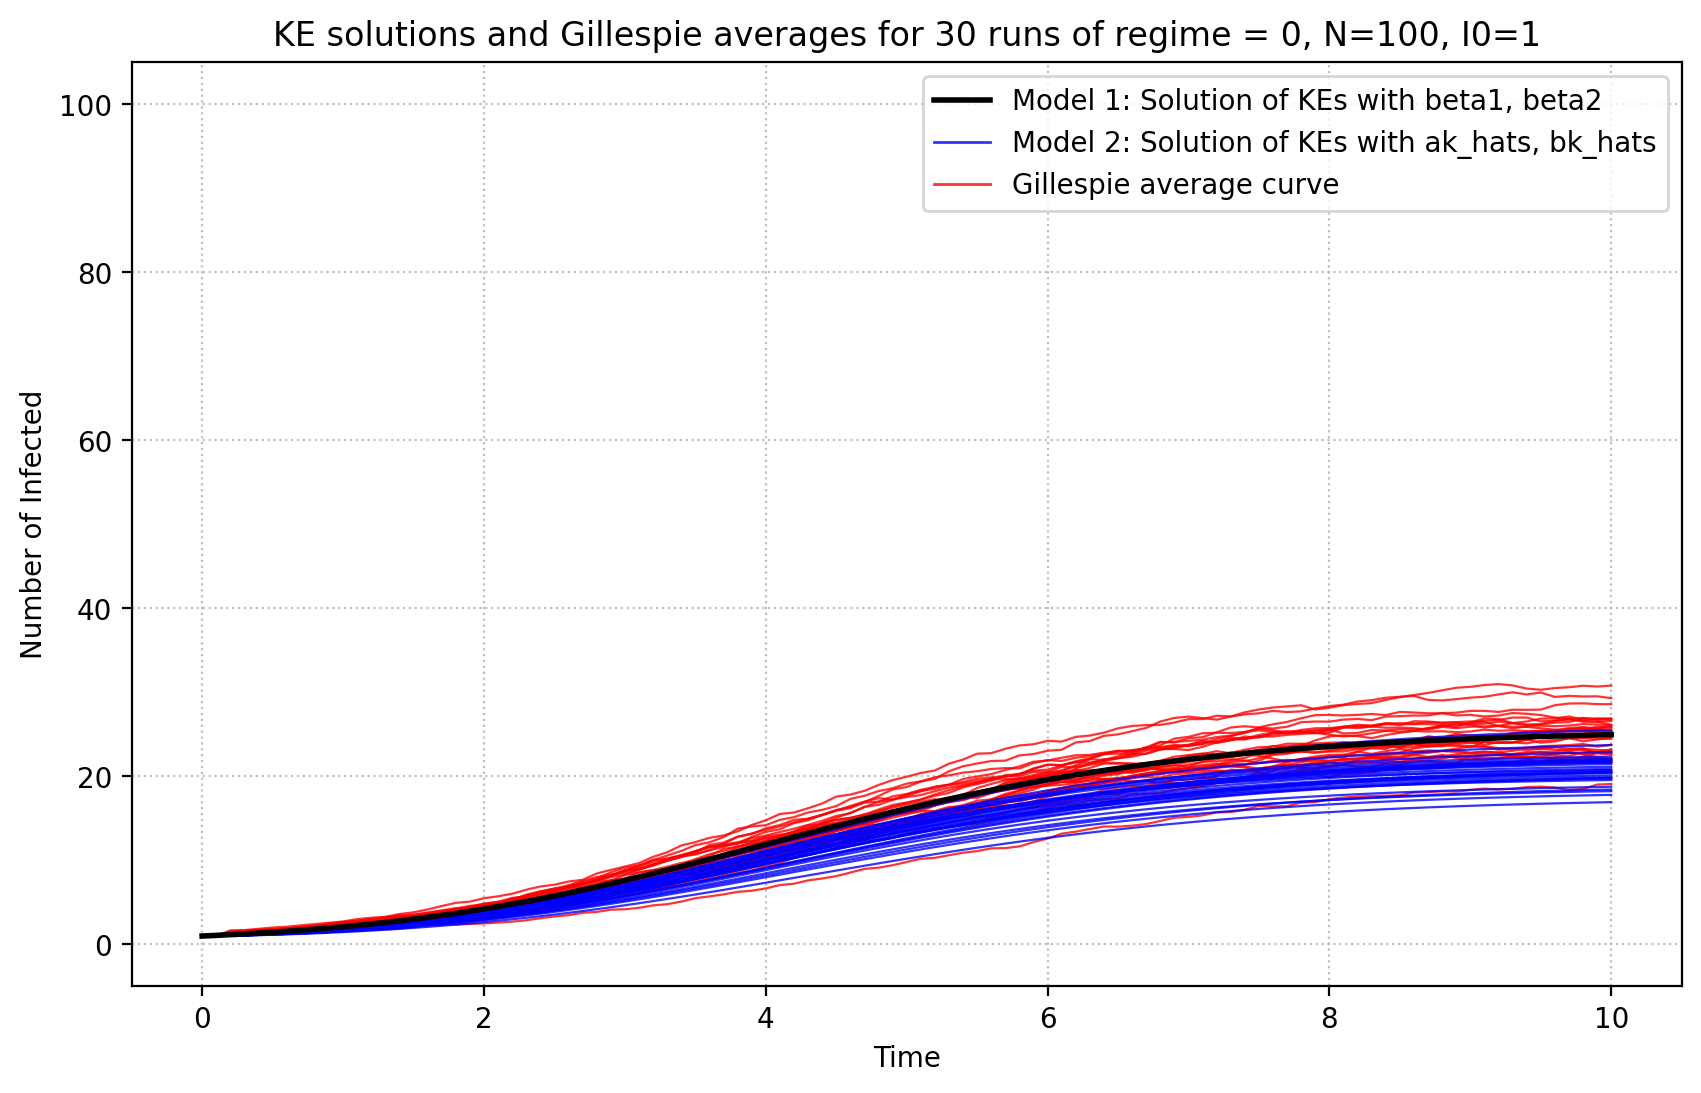

In [26]:
## --- Setup --- ##
test_name = "solution_variability_vs_KE"

I0_compare = 1

selected_regime = 0

betas_unscaled_selected = [(1.778, 2.552), (2.556, 8.241), (5.667, 13.414)]

betas_unscaled = betas_unscaled_selected[selected_regime]
beta1 = betas_unscaled[0] / N
beta2 = betas_unscaled[1] / (N**2)

results_base_dir = "../results/estimation_3"
regime_results_dir = os.path.join(results_base_dir, f"regime_{selected_regime}")
figure_base_dir = "../figures/estimation_3/complete"
figure_dir = os.path.join(figure_base_dir, test_name, f"regime_{selected_regime}")
os.makedirs(figure_dir, exist_ok=True)


fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

# setup KE solver
M = N + 1
p0 = np.zeros(M)
p0[I0_compare] = 1.0

nsteps_ke = 101 # TODO: increase
t_span = (0.0, time_max)

t_eval_ke = np.linspace(t_span[0], t_span[1], nsteps_ke)
min_Tk_threshold = 1e-6

# solve and plot Model 1
ode_system_true = list_all_ODEs_complete(g, beta1, beta2, mu)
sol_true = solve_ivp(lambda t, p: ode_system_true(t, p),
                    t_span, p0, t_eval=t_eval_ke, method="LSODA")

expected_values_true = calculate_expected_values(sol_true)

ax.plot(sol_true.t, expected_values_true, color='black',
        linewidth=2.0, zorder=4)

# for all runs plot averages and estimated solutions of KEs
print(f"\n Processing {nruns} runs for regime {selected_regime} ...")
processed_runs_count = 0
for nrun in range(nruns):
    run_filename = os.path.join(regime_results_dir, f"gillespie-sims_r{nrun}.npz")

    sim_results = np.load(run_filename, allow_pickle=True)
    num_sims_in_file = len(sim_results.files)
    X_sims = [sim_results[f'sim_{i}'] for i in range(num_sims_in_file)]

    # avg gillespie curve
    avg_curve, times_avg = get_average(X_sims, time_max, num_sims_in_file, delta_t=delta_t, selected=2)
    ax.plot(times_avg, avg_curve, color='red', alpha=0.8, linewidth=0.8, zorder=2)

    # calculate estimates for this run
    estimates = calculate_estimates(X_sims, N, min_Tk_threshold)
    a_k_hat = estimates["a_k_hat"]
    b_k_hat = estimates["b_k_hat"]

    # solve estimated KE Model 2 for this run
    ode_system_hat = list_all_ODEs_using_estimates(g, a_k_hat, b_k_hat, mu)
    sol_hat = solve_ivp(lambda t, p: ode_system_hat(t, p),
                        t_span, p0, t_eval=t_eval_ke, method="LSODA")
    
    expected_values_hat = calculate_expected_values(sol_hat)

    # and plot it
    ax.plot(sol_hat.t, expected_values_hat, color='blue', alpha=0.8, linewidth=0.8, zorder=3)
    
    processed_runs_count += 1

print(f"\n Done processing {processed_runs_count} out of {nruns} runs.")


ax.set_xlabel("Time")
ax.set_ylabel("Number of Infected")
title = f"KE solutions and Gillespie averages for {nruns} runs of regime = {selected_regime}, N={N}, I0={I0_compare}"
ax.set_title(title)
ax.grid(True, linestyle=':', alpha=0.8)

legend_elements = [Line2D([0], [0], color='black', lw=2, label='Model 1: Solution of KEs with beta1, beta2'),
                   Line2D([0], [0], color='blue', lw=1, alpha=0.8, label=f'Model 2: Solution of KEs with ak_hats, bk_hats'),
                   Line2D([0], [0], color='red', lw=1, alpha=0.8, label=f'Gillespie average curve')]
ax.legend(handles=legend_elements)

ax.set_ylim(bottom=-N*0.05, top=N*1.05) # TODO: adjust y-limits

output_plot_filename = os.path.join(figure_dir, f"solutions_comparison_variability_N{N}_reg{selected_regime}.pdf")
plt.savefig(output_plot_filename, format='pdf', bbox_inches='tight')
print(f"\nPlot saved to {output_plot_filename}")

plt.show()
plt.close(fig)

## Scatter / Error Bar plot


 Processing 30 runs for regime: 2 ...
Skipping: duration = -0.002420908382124054, event_index = None, index = 1865, sim = 0
Skipping: duration = -0.0002772957146675026, event_index = None, index = 1784, sim = 1
Skipping: duration = -0.012926509238345929, event_index = None, index = 1790, sim = 2
Skipping: duration = -0.005715450907597841, event_index = None, index = 1770, sim = 5
Skipping: duration = -0.0009557062878666756, event_index = None, index = 1845, sim = 6
Skipping: duration = -0.005078581945989313, event_index = None, index = 1660, sim = 7
Skipping: duration = -0.011343258020152902, event_index = None, index = 1623, sim = 8
Skipping: duration = -0.0025219596748353723, event_index = None, index = 1681, sim = 9
Skipping: duration = -0.006203766720579651, event_index = None, index = 1665, sim = 10
Skipping: duration = -0.0016722395639057197, event_index = None, index = 1729, sim = 11
Skipping: duration = -0.0004053490997666387, event_index = None, index = 1723, sim = 12
Skippin

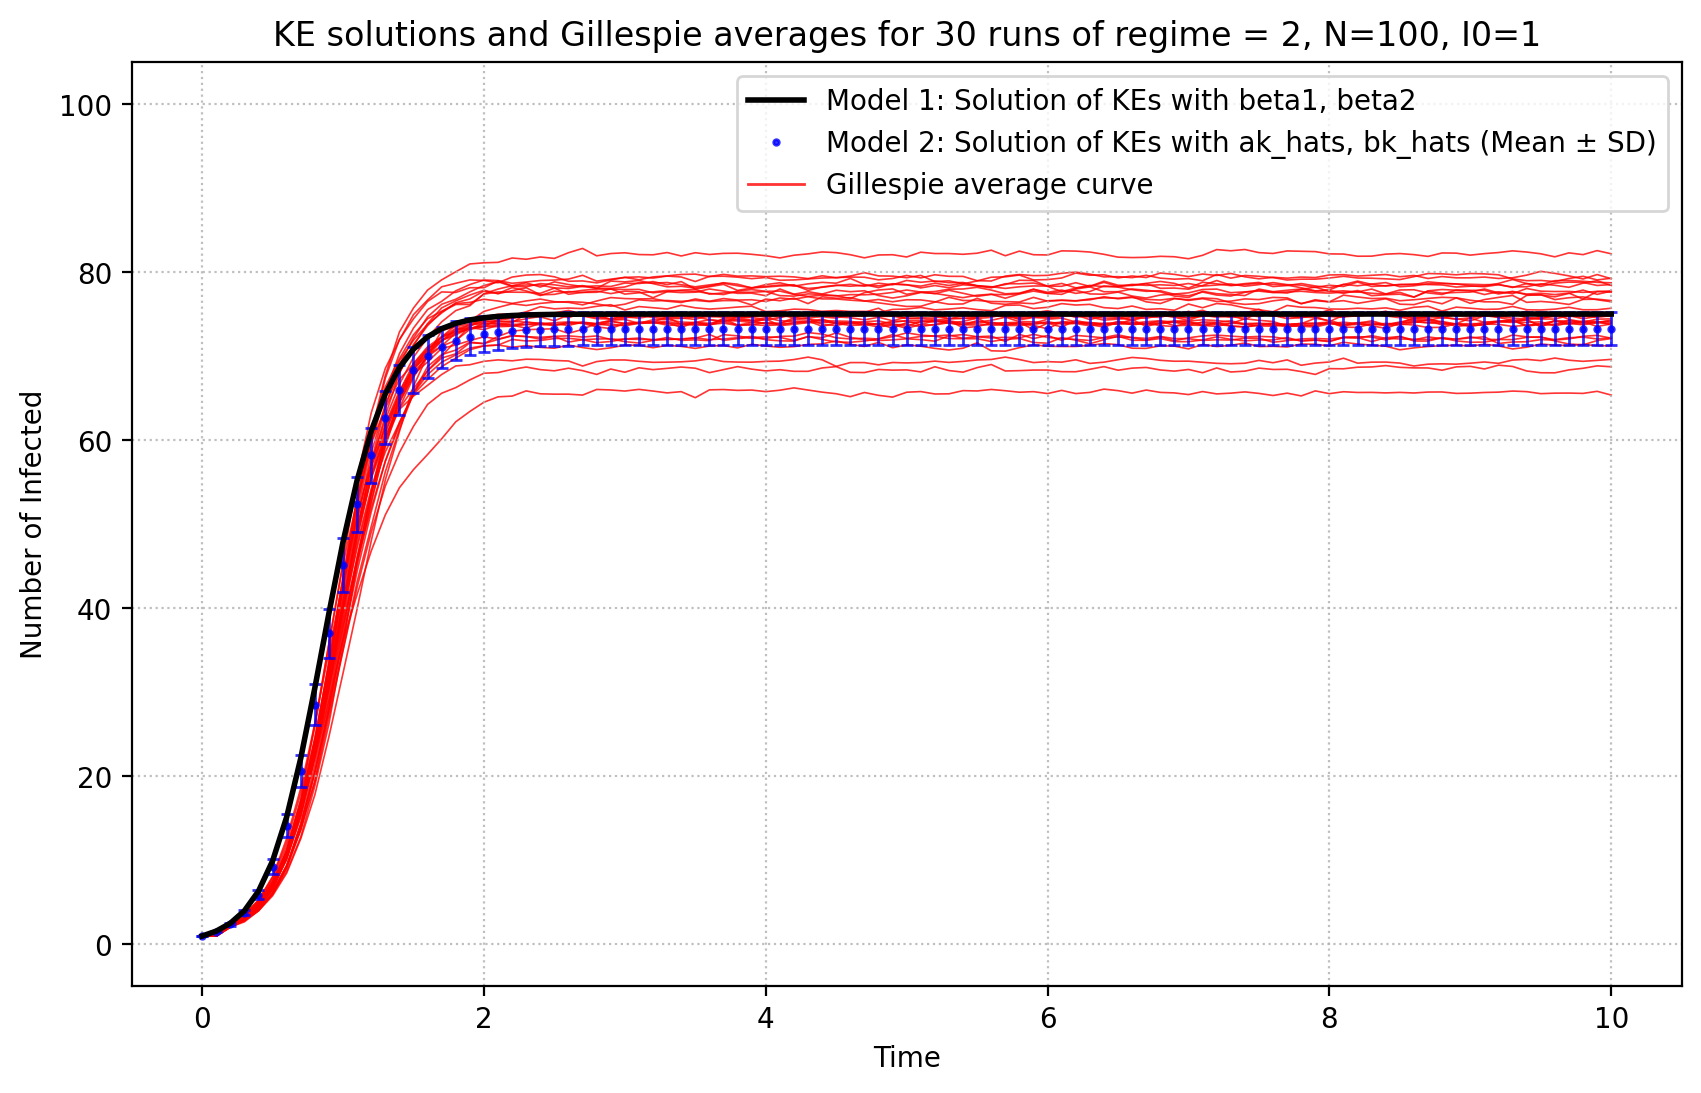

In [29]:
## --- Setup --- ##
test_name = "solution_variability_errorbar"

selected_regime = 2

# select and scale betas for the regime
betas_unscaled = betas_unscaled_selected[selected_regime]
beta1 = betas_unscaled[0] / N
beta2 = betas_unscaled[1] / (N**2)

# input output dir
results_base_dir = "../results/estimation_3"
regime_results_dir = os.path.join(results_base_dir, f"regime_{selected_regime}")
figure_base_dir = "../figures/estimation_3/complete"
figure_dir = os.path.join(figure_base_dir, test_name, f"regime_{selected_regime}")
os.makedirs(figure_dir, exist_ok=True)


# KE solution
M = N + 1
p0 = np.zeros(M)
p0[I0_compare] = 1.0

nsteps_ke = 101 # TODO: increase
t_span = (0.0, time_max)
t_eval_ke = np.linspace(t_span[0], t_span[1], nsteps_ke)
min_Tk_threshold = 1e-6

# store the avg curves
all_avg_gillespie_curves = []
all_times_avg = []
all_est_ke_solutions = []

print(f"\n Processing {nruns} runs for regime: {selected_regime} ...")
processed_runs_count = 0
for nrun in range(nruns):
    run_filename = os.path.join(regime_results_dir, f"gillespie-sims_r{nrun}.npz")

    sim_results = np.load(run_filename, allow_pickle=True)
    num_sims_in_file = len(sim_results.files)
    X_sims = [sim_results[f'sim_{i}'] for i in range(num_sims_in_file)]

    # calculate average gillespie curve
    avg_curve, times_avg = get_average(X_sims, time_max, num_sims_in_file, delta_t=delta_t, selected=2)
    all_avg_gillespie_curves.append(avg_curve)
    if nrun == 0: all_times_avg = times_avg

    # calculate estimates
    estimates = calculate_estimates(X_sims, N, min_Tk_threshold)
    a_k_hat = estimates["a_k_hat"]
    b_k_hat = estimates["b_k_hat"]

    # solve KEs with estimates
    ode_system_hat = list_all_ODEs_using_estimates(g, a_k_hat, b_k_hat, mu)
    sol_hat = solve_ivp(lambda t, p: ode_system_hat(t, p),
                        t_span, p0, t_eval=t_eval_ke, method="LSODA")
    expected_values_hat = calculate_expected_values(sol_hat)

    # and store solution
    all_est_ke_solutions.append(expected_values_hat)

    processed_runs_count += 1

print(f"\n Processed {processed_runs_count} out of {nruns} runs")


# calculate mean and std dev of estimated KE solutions
est_ke_solutions_array = np.array(all_est_ke_solutions)
mean_est_ke = np.nanmean(est_ke_solutions_array, axis=0)
std_est_ke = np.nanstd(est_ke_solutions_array, axis=0, ddof=1)

# remove NaNs
valid_time_idx_ke = ~np.isnan(mean_est_ke)

# solve and plot Model 1 KEs with true beta1, beta2 
ode_system_true = list_all_ODEs_complete(g, beta1, beta2, mu)
sol_true = solve_ivp(lambda t, p: ode_system_true(t, p),
                    t_span, p0, t_eval=t_eval_ke, method="LSODA")

expected_values_true = calculate_expected_values(sol_true)

# plot it
print("\n Generating plot ...")
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

for avg_curve in all_avg_gillespie_curves:
     ax.plot(all_times_avg, avg_curve, color='red', alpha=0.8, linewidth=0.6, zorder=1)

# true KE on top
ax.plot(t_eval_ke, expected_values_true, color='black', linewidth=2.0, zorder=3)

# means and stds of with error bars
ax.errorbar(t_eval_ke[valid_time_idx_ke], mean_est_ke[valid_time_idx_ke], yerr=std_est_ke[valid_time_idx_ke],
            fmt='.', color='blue', markersize=4, elinewidth=1, capsize=2, alpha=0.8,
            label='KE (Mean ± SD)', zorder=2)

ax.set_xlabel("Time")
ax.set_ylabel("Number of Infected")
title = f"KE solutions and Gillespie averages for {nruns} runs of regime = {selected_regime}, N={N}, I0={I0_compare}"
ax.set_title(title)
ax.grid(True, linestyle=':', alpha=0.8)

# Custom legend
# legend_elements = [Line2D([0], [0], color='black', lw=2, label='Model 1: Solution of KEs with beta1, beta2'),
#                    Line2D([0], [0], color='blue', lw=1, alpha=0.8, label=f'Model 2: Solution of KEs with ak_hats, bk_hats'),
#                    Line2D([0], [0], color='red', lw=1, alpha=0.8, label=f'Gillespie average curve')]
legend_elements = [Line2D([0], [0], color='black', lw=2, label='Model 1: Solution of KEs with beta1, beta2'),
                   Line2D([0], [0], marker='.', color='blue', lw=0, markersize=4, alpha=0.8, label=f'Model 2: Solution of KEs with ak_hats, bk_hats (Mean ± SD)'),
                   Line2D([0], [0], color='red', lw=1, alpha=0.8, label=f'Gillespie average curve')]
ax.legend(handles=legend_elements, loc='best')

ax.set_ylim(bottom=-N*0.05, top=N*1.05) # TODO: adjust limits


output_plot_filename = os.path.join(figure_dir, f"solutions_errorbar_N{N}_reg{selected_regime}.pdf")

plt.savefig(output_plot_filename, format='pdf', bbox_inches='tight')
print(f"\nPlot saved successfully to {output_plot_filename}")

plt.show()
plt.close(fig)